# Market Regime-Aware Trading Signal Generation: A PyTorch Approach to Financial Time Series Analysis

## Abstract

This tutorial introduces an approach to generating trading signals using PyTorch by first identifying market regimes through unsupervised learning, then creating specialized models for each regime.
A market regime is a distinct period of time in the market where they can be categorised and clustered to behave in a certain way, for example, a "Consolidation" or "High Volatility", where the price trends upwards. Each regime has different patterns that can be identified and therefore require different trading strategies. This hierarchical ensemble approach adapts to changing market conditions, potentially yielding better performance than traditional methods. The system combines technical indicators with custom features to detect market states and predict price movements, all integrated within a coherent PyTorch framework. We evaluate the model using financial metrics and compare performance across different parameter configurations. The aim of this tutorial is to identify the how these strategies can be implement, and if they can yield result when being used.


### Learning Objectives:

- Understand how to preprocess financial time series data for machine learning
- Implement unsupervised learning techniques to identify market regimes 
- Build a PyTorch-based hierarchical ensemble model for financial prediction
- Evaluate trading strategies using appropriate financial metrics
- Visualize model performance across different market conditions
- Analyze the impact of hyperparameters on trading strategy performance

 ## Introduction

Traditional machine learning approaches to trading signal generation often assume that financial markets follow consistent patterns. However, markets exhibit distinct regimes (trending, volatile, ranging, etc.) where different strategies may prove effective. This tutorial presents a regime-aware trading signal generator that adapts to changing market conditions.

This approach differs from existing tutorials in several ways:

| Aspect | Traditional Approaches | Our Approach |
|--------|------------------------|--------------|
| Market Modeling | Assumes consistent market behavior | Identifies distinct market regimes |
| Model Structure | Single model for all conditions | Specialized models for each regime |
| Adaptability | Limited ability to adapt to changes | Dynamically adjusts to market shifts |
| Feature Utilization | Uses same features throughout | Emphasizes different features by regime |

To begin, the environent must be setup...

## 1. Environment Setup:

Data Processing and Visualisation Libraries:

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Data Aquisition: 

Using Yahoo Finance for the dataset, as it is easily called via this import. It allows calls to fetch historical stock price data for a stock ticker without needing to perform web scraping or manually downloading large datasets.

In [268]:
import yfinance as yf

PyTorch Framework:

This is the deeplearning framework that will be used to build and train the models.

In [269]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

Machine Learning Tools:

Scikit-learn tools imported to help with data preperation, evaluation of the models and also identifying market regimes.

In [270]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

Technical Analysis:

The Technical analysis library calculates financial technical indicators that will be required, such as Bollinger Bands and RSI, to analyse price movements. These indicators are commonly used by traders, so it should allow for more accurate predictions and the creation of identifiers, which will be used to identify clusters.

In [271]:
import ta

Hardware Setup:

Check the runtime system has a CUDA-compatible GPU and then set PyTorch to use it, if available. This should speed up the neural network training time.

In [272]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Reproducability Settings:

To ensure that the randomised sections of this tutorial produce the same results one each run, random seeds should be set.

In [273]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Data Aquisition Function:

The Yahoo finance `download()` function is used for collecting the daily Open, High, Low, Close prices and Trading Volume (OHLCV) for a specified ticker and date range, which is fetched from the Yahoo Fincance servers. The function should return a pandas DataFrame of all the data, indexed by Date.

In [274]:
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

Then provide the date range and ticker to download and view a sample of the data.

In [275]:
start_date = '2010-01-01'
end_date = '2023-01-01'
ticker = 'SPY'

df = get_data(ticker, start_date, end_date)

print(f"Downloaded {len(df)} records for {ticker}")
print("\nData Sample:")
df.head()

[*********************100%***********************]  1 of 1 completed

Downloaded 3272 records for SPY

Data Sample:


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,86.026459,86.072002,84.644935,85.297743,118944600
2010-01-05,86.254166,86.292122,85.662085,85.973310,111579900
2010-01-06,86.314896,86.527437,86.102354,86.170669,116074400
2010-01-07,86.679268,86.785539,85.912596,86.155501,131091100
2010-01-08,86.967751,87.005707,86.276991,86.451576,126402800


Data Preprocessing:

Used for checking and filling in any missing values in the dataset and ensure the date format is configured for the following uses.

In [276]:
def preprocess_data(df):
    data = df.copy()
    
    missing_values = data.isnull().sum()
    print(f"Missing values before handling:\n{missing_values}")
    
    data.fillna(method='ffill', inplace=True)
    
    remaining_missing = data.isnull().sum().sum()
    if remaining_missing > 0:
        data.dropna(inplace=True)
        print(f"Dropped {remaining_missing} rows with missing values")
    
    data = data.reset_index()
    
    data['Date'] = pd.to_datetime(data['Date'])
    
    data = data.sort_values('Date')
    
    print(f"Final dataset shape: {data.shape}")
    return data

In [277]:
preprocessed_df = preprocess_data(df)
preprocessed_df.head()

Missing values before handling:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64
Final dataset shape: (3272, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY
0,2010-01-04,86.026459,86.072002,84.644935,85.297743,118944600
1,2010-01-05,86.254166,86.292122,85.662085,85.973310,111579900
2,2010-01-06,86.314896,86.527437,86.102354,86.170669,116074400
3,2010-01-07,86.679268,86.785539,85.912596,86.155501,131091100
4,2010-01-08,86.967751,87.005707,86.276991,86.451576,126402800


### Feature Engineering:

This is a transformation of the raw data into meaningful inputs that the model can learn from. Creating technical indicators that traders have used historically to predict market movements is useful for a financial time series model. This is designed to further improve the network's understanding of the market regimes by using more advanced financial signals. There are 4 main types of indicators that will be used, aswell as some additional features, which will be introduced to allow the model to learn that certain combinations of indicators typically appear in a given market regime, as well as detecting a shift from one regime to another. By combining these indicators into a single, new dataset, the network should also be able to better distinguish between false signals and actual shifts. This implementation should prevent overfitting, as the trend should not be memorised and reproduced, but instead the regime should first be identified. 

For this section, GenAI was used to aid me in identifying the most important idicators, as well as engineering these features into the improved dataset, as it is not the core focus of this Tutorial. Many of these indicators have been used in existing Machine Learning Pipelines, specficially Moving Averages and Relative Strength Index, however in order to effectively tranform this dataset into one that can effectively identify regimes, these more advanced methods were required.

These additional features will be the basis of the K-means clustering and clasification. 

Although these points are not completely relevant to the machine learning pipeline, it is important to understand the transformation required to get meaningful data that would be used by a human in identifying what regime a market is currently in.

In [278]:
def engineer_features(df, lookback_window=10):
    data = df.copy()
    data = _handle_multi_index_columns(data)
    data = _add_trend_indicators(data)
    data = _add_momentum_indicators(data)
    data = _add_volatility_indicators(data)
    data = _add_volume_indicators(data)
    data = _add_custom_features(data, lookback_window)
    data = _create_target_and_cleanup(data)
    
    print(f"Engineered features shape: {data.shape}")
    print(f"Number of features created: {len(data.columns) - 7}")  
    
    return data

The Yahoo Finance data set provided by the library has a two level column structure, with the SPY ticker repeated for each column. As I will only be using data from a single ticker (SPY), it will be much easier to convert the MultiIndex pandas table into a single level column table in the `_handle_multi_index_columns()` method:

In [279]:
def _handle_multi_index_columns(data):
    if isinstance(data.columns, pd.MultiIndex):
        print("Flattening multi-level columns...")
        data = data.xs('SPY', axis=1, level='Ticker', drop_level=False)
        data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    
    print(f"Column structure after flattening: {data.columns}")
    return data

Trend Indicators:

This is used for indentification of the direction the market is moving - and how string that movement is relative to others. 
- Moving Averages (SMA) is taking the prices over the last 5,10,20 and 50 days , which focuses on the general direction of the price and avoiding the daily noise and volatility.
- Moving Averages Convergence Divergence (MACD) is comparing the fast and slow moving averages.
- Average Directional Index (ADEX) ignore the direction of the trend, but rather the 'strength'.

These indicators are implemented in the `_add_trend_indicators()` function:

In [280]:
def _add_trend_indicators(data):
    data['sma_5'] = data['Close'].rolling(window=5).mean()
    data['sma_10'] = data['Close'].rolling(window=10).mean()
    data['sma_20'] = data['Close'].rolling(window=20).mean()
    data['sma_50'] = data['Close'].rolling(window=50).mean()
    
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()
    
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'])
    data['adx'] = adx.adx()
    data['adx_pos'] = adx.adx_pos()
    data['adx_neg'] = adx.adx_neg()
    
    return data

Momentum Indicators:

Used to measure the speed of price movements

- Relative Strength Index (RSI) is a commonly used indicator to identify if a stock or instrument is 'overbought' or 'oversold', which is a key indicator for bull or bear markets. For example, readings above 70 generally indicate
- Stochastic Oscillator is an indicator which measures the difference between the current price of the stock compared to its range over time, to gauge its relative rpice compared to where it generally has sat.
- Rate of Change (ROC) simply measures how fast the close price has changed over a set period of 5 and 10 days, to see how much steeper the gradient is compared to then.

These indicators are implemented in the `_add_momentum_indicators` function:

In [281]:
def _add_momentum_indicators(data):
    data['rsi'] = ta.momentum.RSIIndicator(data['Close']).rsi()
    
    stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
    data['stoch_k'] = stoch.stoch()
    data['stoch_d'] = stoch.stoch_signal()
    
    data['roc_5'] = ta.momentum.ROCIndicator(data['Close'], window=5).roc()
    data['roc_10'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()
    
    return data

Volatility Indicators:

Volatility refers to the fluctuation of a stock, which is a large sign of what regime a market is in.

- Bollinger Bands create a 'normal range' around the price at a given time, and once the price leaves that band, something out of the ordinary may be happening, and this event must be noted down.
- Average True Range (ATR) measures how much the price changes per day, using the open, close, high and low prices, to see how much the average change differes day by day. A high ATR is a sign of a more volatile market.

These indicators are implemented in the `_add_volatility_indicators()` function

In [282]:
def _add_volatility_indicators(data):
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_width'] = bollinger.bollinger_wband()
    
    data['atr'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close']).average_true_range()
    
    return data

Volume Indicators:

Analysis of how much stock is traded per day. In a bull market, volume is likely to be higher as there are more participants in the market looking to make the most of the rise. However, it is not always as straight forward as this, so more advanced metrics are required:

- On-Balance Volume (OBV) acts as 'net volume' where volume is added to a sum on up days, and sutracts the volume on down days.
- Volume Weighted Average Price (VWAP) calculates the average price weighted by the volume of trades completed at each price.

These indicators are implemented in the `_add_volume_indicators()` function

In [283]:
def _add_volume_indicators(data):
    data['obv'] = ta.volume.OnBalanceVolumeIndicator(data['Close'], data['Volume']).on_balance_volume()
    
    data['vwap'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
    
    return data


Additional insights can be found by implementing additional points to the data set

- Volatility measures implemented to check how much prices are moving when increaing or decreasing rapidly.
- Price Volume Correlation is used to see if when relative movement between the change in price and the change in volatility. Do more people buy when the price goes up? Or does the volume decrease more as the price rises, signalling that people are looking for a bargain.
- Gap Analysis looks at the difference between the close price of one day and the opneing price of the next day.

In [284]:
def _add_custom_features(data, lookback_window):
    data['volatility'] = data['Close'].pct_change().rolling(lookback_window).std() * np.sqrt(252) 
    data['volatility_change'] = data['volatility'].pct_change()
    
    data['trend_strength'] = np.abs(data['Close'].pct_change(lookback_window))
    
    data['volume_trend'] = (data['Volume'] / data['Volume'].rolling(20).mean()) * data['Close'].pct_change()
    
    close_pct = data['Close'].pct_change()
    volume_pct = data['Volume'].pct_change()
    
    temp_df = pd.DataFrame({'close_pct': close_pct, 'volume_pct': volume_pct})
    data['price_volume_correlation'] = temp_df['close_pct'].rolling(window=lookback_window).corr(temp_df['volume_pct'])
    
    data['gap_up'] = (data['Open'] > data['Close'].shift(1)).astype(int)
    data['gap_down'] = (data['Open'] < data['Close'].shift(1)).astype(int)
    
    data['daily_return'] = data['Close'].pct_change()
    data['weekly_return'] = data['Close'].pct_change(5)
    data['monthly_return'] = data['Close'].pct_change(21)
    
    return data

Identifying a target:

Create targets, which are binary classifiers 0 or 1 if the price should go up or down the next day. These will act as the output classes, and they can be easily compared with what actually happens in the data. Moreover, these methods could potentially create some null values due to rolling calculations, so these are dropped from the table.

In [285]:
def _create_target_and_cleanup(data):
    data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data.dropna(inplace=True)
    
    return data

So overall, 31 additional measures have been added to the dataset taking a (3223, 7) input matrix to a shape of (3223, 38). (please note: This is before the data has been sepearted into traing and testing sets).

In [286]:
feature_df = engineer_features(preprocessed_df, lookback_window=10)
print("\nFeature sample:")
feature_df.head()

Flattening multi-level columns...
Column structure after flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Engineered features shape: (3223, 38)
Number of features created: 31

Feature sample:


,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,volatility_change,trend_strength,volume_trend,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target
49,88.364403,88.447896,87.666046,87.908951,168673000,87.716159,86.967712,85.597577,84.704742,1.115701,...,0.060421,0.037522,0.007905,0.559475,1,0,0.007966,0.017036,0.077471,1
50,88.888199,89.176653,88.372025,88.630115,177468100,88.039529,87.332069,85.857183,84.761977,1.205486,...,-0.015180,0.042743,0.006173,0.544531,1,0,0.005928,0.018527,0.067068,0
51,88.842644,89.017229,88.485876,88.895779,196509100,88.280917,87.666067,86.089843,84.813747,1.258458,...,0.054338,0.039063,-0.000590,0.481272,1,0,-0.000512,0.013772,0.061491,0
52,88.392937,89.399047,88.049941,88.392937,226641100,88.430846,87.832878,86.291286,84.855308,1.249745,...,-0.190104,0.019235,-0.006719,0.097117,0,1,-0.005062,0.008553,0.049929,1
53,88.865501,89.025570,87.836526,87.889880,184477800,88.670737,88.045428,86.515597,84.899032,1.266374,...,0.023500,0.024504,0.005689,-0.157116,0,1,0.005346,0.013682,0.053357,1


### Market Regime Identification

Market regimes are distinct periods with similar characteristics in financial markets. They can be:
- Bull markets (upward trends)
- Bear markets (downward trends)
- High volatility periods
- Low volatility periods

The functions `identify_market_regimes()` use K-means clustering on technical indicators to identify these regimes automatically. It does this by chosing features in the dataset relevant to identifying clusters in the data.


In [287]:
def identify_market_regimes(data, n_clusters=7, features=None):
    market_data = data.copy()
    
    if features is None:
        features = ['volatility', 'adx', 'rsi', 'bollinger_width']
    
    existing_features = [f for f in features if f in market_data.columns]
    
    if len(existing_features) == 0:
        if 'volatility' in market_data.columns:
            existing_features = ['volatility']
        else:
            market_data['volatility'] = market_data['Close'].pct_change().rolling(10).std() * np.sqrt(252)
            existing_features = ['volatility']
    
    X = market_data[existing_features].copy()
    X.fillna(X.mean(), inplace=True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    market_data['regime_id'] = kmeans.fit_predict(X_scaled)
    
    centroids = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=existing_features
    )
    print("Cluster centroids (representing each regime's characteristics):")
    print(centroids)
    
    regime_names = {}
    
    if 'volatility' in existing_features:
        volatility_idx = existing_features.index('volatility')
        volatilities = [centroid[volatility_idx] for centroid in kmeans.cluster_centers_]
        
        sorted_regimes = sorted(range(n_clusters), key=lambda i: volatilities[i])
        
        regime_names[sorted_regimes[0]] = "Low Volatility"
        regime_names[sorted_regimes[-1]] = "High Volatility"
        
        if len(sorted_regimes) > 2:
            for i in sorted_regimes[1:-1]:
                if 'adx' in existing_features and centroids.loc[i, 'adx'] > 25:
                    if 'rsi' in existing_features:
                        if centroids.loc[i, 'rsi'] > 60:
                            regime_names[i] = "Bullish Trend"
                        elif centroids.loc[i, 'rsi'] < 40:
                            regime_names[i] = "Bearish Trend"
                        else:
                            regime_names[i] = "Neutral Trend"
                    else:
                        regime_names[i] = "Strong Trend"
                else:
                    regime_names[i] = "Consolidation"
    else:
        for i in range(n_clusters):
            regime_names[i] = f"Regime {i+1}"
    
    market_data['regime'] = market_data['regime_id'].map(regime_names)
    
    print("\nIdentified Market Regimes:")
    for regime_id, name in regime_names.items():
        print(f"Regime {regime_id}: {name}")
        regime_data = market_data[market_data['regime_id'] == regime_id]
        if 'daily_return' in market_data.columns:
            avg_return = regime_data['daily_return'].mean() * 100
            print(f"  - Average Daily Return: {avg_return:.2f}%")
        if 'volatility' in market_data.columns:
            avg_vol = regime_data['volatility'].mean() * 100
            print(f"  - Average Volatility: {avg_vol:.2f}%")
        print(f"  - Number of Days: {len(regime_data)}")
    
    return market_data

Looking to Identify all 7 clusters:

In [288]:
data_with_regimes = identify_market_regimes(feature_df, n_clusters=7)

Cluster centroids (representing each regime's characteristics):
   volatility        adx        rsi  bollinger_width
0    0.099240  14.891917  57.212689         3.528839
1    0.269866  31.326716  40.682637        10.963420
2    0.152407  21.862100  44.367623         4.897276
3    0.079610  32.921972  69.364749         4.873479
4    0.222132  18.260995  56.542334         9.190802
5    0.728090  37.755611  41.386122        29.437320
6    0.092330  22.014408  65.298554         5.545644

Identified Market Regimes:
Regime 3: Low Volatility
  - Average Daily Return: 0.13%
  - Average Volatility: 7.96%
  - Number of Days: 420
Regime 5: High Volatility
  - Average Daily Return: -0.13%
  - Average Volatility: 72.81%
  - Number of Days: 39
Regime 6: Consolidation
  - Average Daily Return: 0.20%
  - Average Volatility: 9.23%
  - Number of Days: 665
Regime 0: Consolidation
  - Average Daily Return: 0.12%
  - Average Volatility: 9.92%
  - Number of Days: 778
Regime 2: Consolidation
  - Average Dail

Identifying just 4 market regime clusters:

In [289]:
data_with_regimes = identify_market_regimes(feature_df, n_clusters=4)

Cluster centroids (representing each regime's characteristics):
   volatility        adx        rsi  bollinger_width
0    0.085002  28.054816  67.727047         5.331073
1    0.239661  27.145677  43.465304         9.399715
2    0.123192  17.017061  55.413732         4.612989
3    0.705344  37.566906  40.956004        28.513129

Identified Market Regimes:
Regime 0: Low Volatility
  - Average Daily Return: 0.17%
  - Average Volatility: 8.48%
  - Number of Days: 873
Regime 3: High Volatility
  - Average Daily Return: -0.05%
  - Average Volatility: 70.53%
  - Number of Days: 43
Regime 2: Consolidation
  - Average Daily Return: 0.07%
  - Average Volatility: 12.31%
  - Number of Days: 1616
Regime 1: Neutral Trend
  - Average Daily Return: -0.13%
  - Average Volatility: 23.95%
  - Number of Days: 691


Using k-means clustering, I identified that increasing the amount of clusters that could be identified was a maximum of 4 distinct market regimes, meaning that within this dataset, increasing clusters just creates finer graduations within existing market regimes rather than identifying new distinctive regimes. This could be because my data natutally splits into the 4 main regime types regardless of how many clusters requested, or that the feature set requires expansion to detect more nuanced market detectors.

In [290]:
def visualize_market_regimes(data_with_regimes):
    color_map = {
        "Low Volatility": "green",
        "High Volatility": "red",
        "Consolidation": "gray",
        "Bullish Trend": "blue",
        "Bearish Trend": "orange",
        "Neutral Trend": "purple",
        "Strong Trend": "brown"
    }
    
    plt.figure(figsize=(14, 7))
    
    # Determine date column
    if 'Date' in data_with_regimes.columns:
        date_col = 'Date'
    elif isinstance(data_with_regimes.index, pd.DatetimeIndex):
        data_with_regimes = data_with_regimes.reset_index()
        date_col = 'index'
    else:
        data_with_regimes['date_seq'] = np.arange(len(data_with_regimes))
        date_col = 'date_seq'
    
    # Get unique regimes
    unique_regimes = data_with_regimes['regime'].unique()
    
    # Plot each regime with different color
    for regime in unique_regimes:
        mask = data_with_regimes['regime'] == regime
        color = color_map.get(regime, "black")  
        plt.scatter(data_with_regimes.loc[mask, date_col], 
                   data_with_regimes.loc[mask, 'Close'], 
                   label=regime, alpha=0.7, c=color)
    
    plt.title('Stock Price by Market Regime', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(title="Market Regimes", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return data_with_regimes

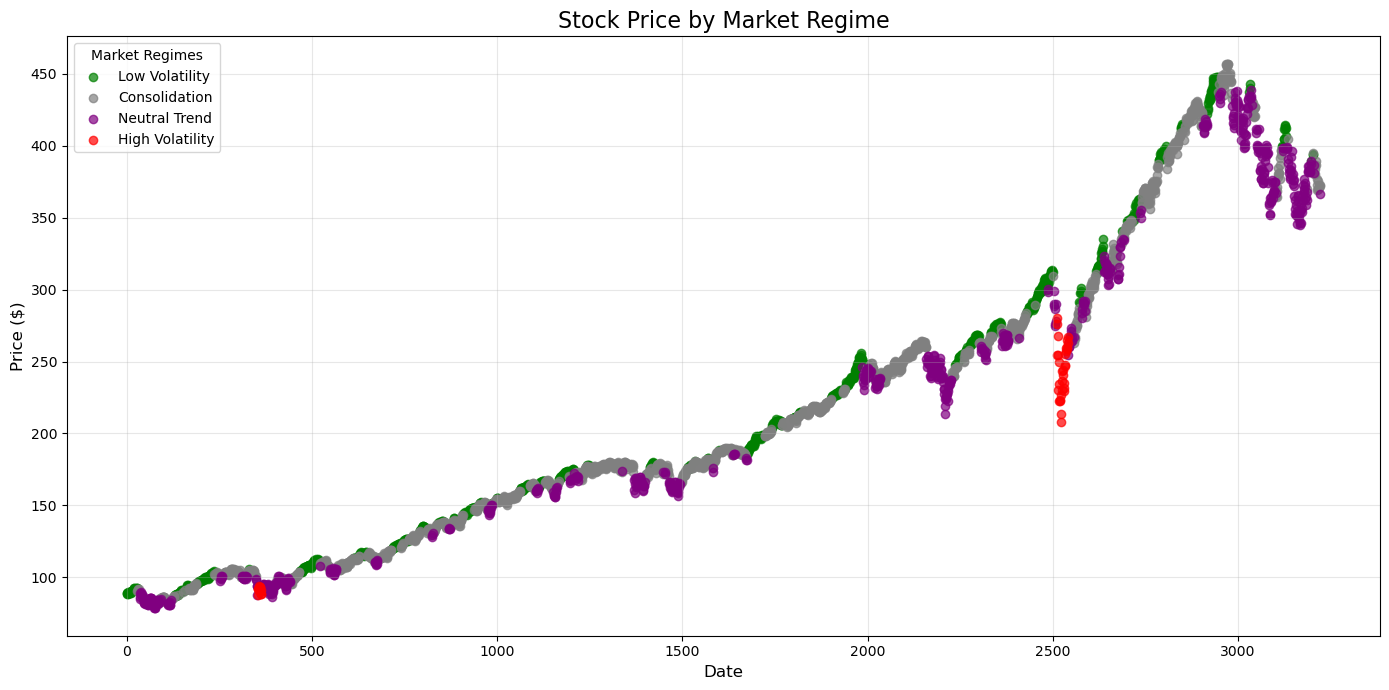

,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target,regime_id,regime,date_seq
49,88.364403,88.447896,87.666046,87.908951,168673000,87.716159,86.967712,85.597577,84.704742,1.115701,...,0.559475,1,0,0.007966,0.017036,0.077471,1,0,Low Volatility,0
50,88.888199,89.176653,88.372025,88.630115,177468100,88.039529,87.332069,85.857183,84.761977,1.205486,...,0.544531,1,0,0.005928,0.018527,0.067068,0,0,Low Volatility,1
51,88.842644,89.017229,88.485876,88.895779,196509100,88.280917,87.666067,86.089843,84.813747,1.258458,...,0.481272,1,0,-0.000512,0.013772,0.061491,0,0,Low Volatility,2
52,88.392937,89.399047,88.049941,88.392937,226641100,88.430846,87.832878,86.291286,84.855308,1.249745,...,0.097117,0,1,-0.005062,0.008553,0.049929,1,0,Low Volatility,3
53,88.865501,89.025570,87.836526,87.889880,184477800,88.670737,88.045428,86.515597,84.899032,1.266374,...,-0.157116,0,1,0.005346,0.013682,0.053357,1,0,Low Volatility,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,372.400513,372.546390,367.654446,369.229978,59857300,371.597192,376.998004,381.598331,375.679816,-1.936061,...,-0.013248,0,1,0.005752,-0.000939,-0.044112,0,2,Consolidation,3218
3268,370.931976,372.633945,369.230007,372.283840,51638200,371.865619,375.468530,380.980746,376.173965,-2.231737,...,0.032718,0,1,-0.003943,0.003631,-0.047669,0,2,Consolidation,3219
3269,366.322083,372.867380,366.088679,370.863892,70911500,371.110919,373.185696,380.165582,376.397979,-2.805699,...,-0.409057,0,1,-0.012428,-0.010196,-0.044253,1,1,Neutral Trend,3220
3270,372.915985,373.801013,368.675636,369.210558,66970900,370.568237,371.811060,379.077464,376.670420,-2.697402,...,-0.373798,1,0,0.018000,-0.007224,-0.025376,0,2,Consolidation,3221


In [291]:
visualize_market_regimes(data_with_regimes)

## LSTM Architecture

The `NumericalOnlyModel` class defines the architecture of a base model using a Long Short-Term Memory network to work with the numerical inputs. 

- Firstly, taking the sequential set of numerical (price) data
- Temporal Patterns are captured through the LSTM, while only retaining the final output.
- Additional Dropout Layer between LSTM layers to yield a more 'generalised' understanding of the data and prevent overfitting.
- A Fully Connected Layer reduces the hidden dimension to get a single output.
- The activation function used was the sigmoid, as it squeezes values between 0 and 1, which is useful for the binary clasification used.


In [292]:
class NumericalOnlyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(NumericalOnlyModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        out = self.dropout(last_time_step)
        out = self.fc(out)
        out = self.sigmoid(out).squeeze()
        return out

The `RegimeAwareModel()` class defines a very similair model, using an LSTM network with droput and fully sonnected layers, however has an additional embedded layer to represent market regimes as learned vectors.

In [293]:
class RegimeAwareModel(nn.Module):
    def __init__(self, input_dim, num_regimes, hidden_dim=64, num_layers=2, dropout=0.2):
        super(RegimeAwareModel, self).__init__()
        self.regime_embedding = nn.Embedding(num_regimes, 8)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(hidden_dim + 8, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, regime):
        # Process time series with LSTM
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        
        # Get regime embeddings
        regime_emb = self.regime_embedding(regime)
        
        # Concatenate LSTM output with regime embedding
        combined = torch.cat((last_time_step, regime_emb), dim=1)
        
        # Final prediction combining both sources of information
        out = self.dropout(combined)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        out = self.sigmoid(out).squeeze()
        
        return out

A PyTorch Dataset for Financial Time Series Data

In [294]:
class FinancialDataset(Dataset):
    def __init__(self, data, seq_length=10, target_col='target'):
        self.data = data
        self.seq_length = seq_length
        self.target_col = target_col
        
        # Select numerical features, excluding date, target, and object columns
        self.feature_cols = [col for col in data.columns 
                           if col != 'Date' and col != target_col 
                           and col != 'regime' and col != 'regime_id'
                           and data[col].dtype != 'object']
        
        # Scale the numerical features
        self.scaler = StandardScaler()
        self.normalized_data = self.scaler.fit_transform(data[self.feature_cols])
        
        # Convert to PyTorch tensors
        self.X_tensor = torch.FloatTensor(self.normalized_data)
        self.y_tensor = torch.FloatTensor(data[target_col].values)
        
        # Convert regime IDs to integers for the embedding layer
        if 'regime_id' in data.columns:
            self.regime_tensor = torch.LongTensor(data['regime_id'].values)
        else:
            # If no regime information, just use zeros
            self.regime_tensor = torch.zeros(len(data), dtype=torch.long)
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        X_sequence = self.X_tensor[idx:idx+self.seq_length]
        
        # Get target (next day price movement)
        y_target = self.y_tensor[idx+self.seq_length]
        
        # Get regime label for the sequence (use the most recent regime)
        regime = self.regime_tensor[idx+self.seq_length-1]
        
        return X_sequence, y_target, regime

In [295]:
def prepare_data(data, seq_length=10, train_ratio=0.7, val_ratio=0.15, batch_size=32, random_state=42):
    # Add daily returns (percent change in closing price)
    if 'daily_return' not in data.columns:
        data['daily_return'] = data['Close'].pct_change()
    
    # Create target variable (1 if price goes up tomorrow, 0 otherwise)
    if 'target' not in data.columns:
        data['target'] = (data['Close'].shift(-1) > data['Close']).astype(float)
    
    # Remove NaN values
    data = data.dropna()
    
    # Shuffle the data
    shuffled_data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Split data
    train_size = int(len(shuffled_data) * train_ratio)
    val_size = int(len(shuffled_data) * val_ratio)
    
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size+val_size]
    test_data = data.iloc[train_size+val_size:] 
    
    print(f"Data split: {len(train_data)} training, {len(val_data)} validation, {len(test_data)} test samples")
    
    # Create datasets
    train_dataset = FinancialDataset(train_data, seq_length=seq_length)
    val_dataset = FinancialDataset(val_data, seq_length=seq_length)
    test_dataset = FinancialDataset(test_data, seq_length=seq_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Get information for model creation
    input_dim = len(train_dataset.feature_cols)
    num_regimes = len(data['regime'].unique()) if 'regime' in data.columns else 1
    
    print(f"Input features: {input_dim}")
    print(f"Number of regimes: {num_regimes}")
    print(f"Feature columns used: {train_dataset.feature_cols[:5]}... (showing first 5)")
    
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'input_dim': input_dim,
        'num_regimes': num_regimes,
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data
    }

In [296]:
data_prep = prepare_data(data_with_regimes, seq_length=10, batch_size=32)


Data split: 2256 training, 483 validation, 484 test samples
Input features: 38
Number of regimes: 4
Feature columns used: ['Close', 'High', 'Low', 'Open', 'Volume']... (showing first 5)


## Training 

In [297]:
def train_epoch(model, train_loader, criterion, optimizer, device, regime_aware=False):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, regime_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        if regime_aware:
            regime_batch = regime_batch.to(device)
            y_pred = model(X_batch, regime_batch)
        else:
            y_pred = model(X_batch)
            
        # Calculate loss
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Return average loss
    return total_loss / len(train_loader)

Hyperparameter Tuning:

In [298]:
def hyperparameter_tuning(data, params_grid):
    results = []
    
    # Split the data
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.15)
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size+val_size]
    
    for seq_length in params_grid['seq_length']:
        for hidden_dim in params_grid['hidden_dim']:
            for num_layers in params_grid['num_layers']:
                for dropout in params_grid['dropout']:
                    for lr in params_grid['learning_rate']:
                        for batch_size in params_grid['batch_size']:
                            # Create datasets and loaders
                            train_dataset = FinancialDataset(train_data, seq_length=seq_length)
                            val_dataset = FinancialDataset(val_data, seq_length=seq_length)
                            
                            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                            val_loader = DataLoader(val_dataset, batch_size=batch_size)
                            
                            # Create models
                            input_dim = len(train_dataset.feature_cols)
                            num_regimes = len(data['regime'].unique())
                            
                            # Standard model
                            model = NumericalOnlyModel(input_dim, hidden_dim, num_layers, dropout).to(device)
                            
                            # Train and evaluate
                            _, _, val_accuracies = train_model(
                                model, train_loader, val_loader, epochs=20, lr=lr, regime_aware=False
                            )
                            
                            # Store results
                            results.append({
                                'seq_length': seq_length,
                                'hidden_dim': hidden_dim,
                                'num_layers': num_layers,
                                'dropout': dropout,
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'val_accuracy': max(val_accuracies)
                            })
    
    # Convert to DataFrame and sort by validation accuracy
    results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
    return results_df

## Model Evaluation:

In [299]:
def evaluate_model(model, data_loader, criterion, device, regime_aware=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, regime_batch in data_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            if regime_aware:
                regime_batch = regime_batch.to(device)
                y_pred = model(X_batch, regime_batch)
            else:
                y_pred = model(X_batch)
            
            # Calculate loss
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = (y_pred > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    # Return average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

Results Visualisation and Analysis:

In [300]:
def train_model(model, train_loader, val_loader, device, epochs=3, lr=0.001, regime_aware=False):
    # Set up loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler to reduce LR when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Keep track of best validation accuracy
    best_val_acc = 0
    
    # Training loop
    for epoch in range(epochs):
        # Train one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, regime_aware)
        history['train_loss'].append(train_loss)
        
        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device, regime_aware)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Print progress every few epochs
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return history

In [301]:
def plot_training_history(history, title="Model Training History"):
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
    plt.legend()
    
    # Plot learning rate if available
    if 'learning_rates' in history and history['learning_rates']:
        plt.subplot(1, 3, 3)
        plt.plot(history['learning_rates'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [302]:
standard_model = NumericalOnlyModel(
    input_dim=data_prep['input_dim'], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

regime_model = RegimeAwareModel(
    input_dim=data_prep['input_dim'],
    num_regimes=data_prep['num_regimes'],
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
).to(device)


Epoch 1/10, Train Loss: 0.6896, Val Loss: 0.6830, Val Accuracy: 0.5793
Epoch 5/10, Train Loss: 0.6863, Val Loss: 0.6877, Val Accuracy: 0.5518
Epoch 10/10, Train Loss: 0.6654, Val Loss: 0.6935, Val Accuracy: 0.5433
Best validation accuracy: 0.5793
Epoch 1/10, Train Loss: 0.6894, Val Loss: 0.6831, Val Accuracy: 0.5793
Epoch 5/10, Train Loss: 0.6848, Val Loss: 0.6837, Val Accuracy: 0.5793
Epoch 10/10, Train Loss: 0.6709, Val Loss: 0.6974, Val Accuracy: 0.5243
Best validation accuracy: 0.5793


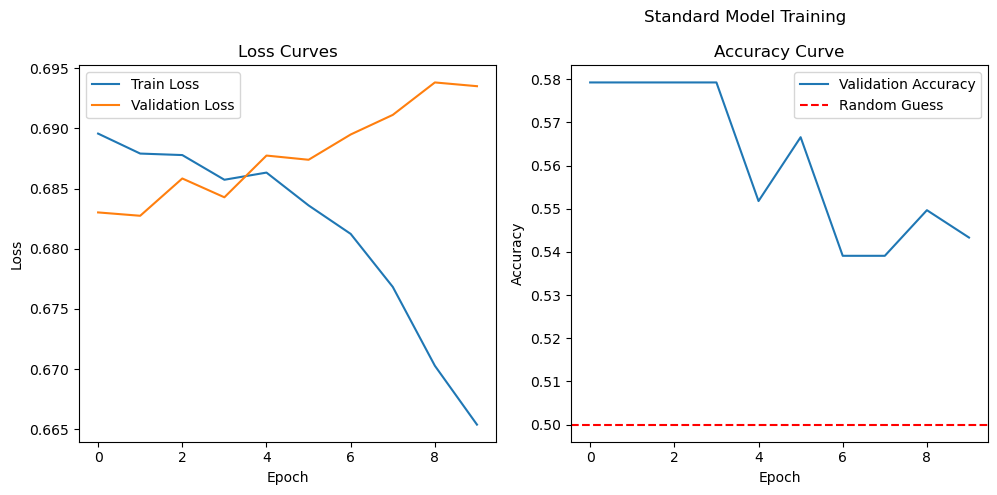

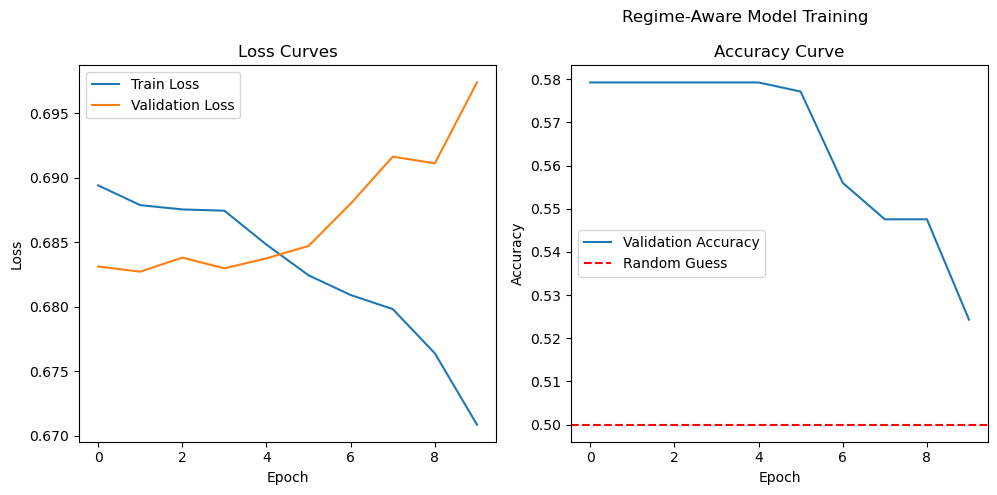

In [303]:
history = train_model(
    standard_model,
    data_prep['train_loader'],
    data_prep['val_loader'],
    device,
    epochs=10,  
    lr=0.001,
    regime_aware=False
)
historyRegimeWise = train_model(
    regime_model,
    data_prep['train_loader'],
    data_prep['val_loader'],
    device,
    epochs=10,  
    lr=0.001,
    regime_aware=True
)

# 4. Visualize training progress
plot_training_history(history, title="Standard Model Training")
plot_training_history(historyRegimeWise, title="Regime-Aware Model Training")

Both of these initial model show that the data is completely overfitted, even though dropout has been implemented. Divergence occurs after Epoch 4/5.

In [304]:
class ImprovedRegimeModel(nn.Module):
    def __init__(self, input_dimension, num_of_regimes, hidden_dimensions=32, num_of_layers=1, dropout=0.4):
        super(ImprovedRegimeModel, self).__init__()
        
        # smaller embedding dimension for market regimes
        self.regime_embedding = nn.Embedding(num_of_regimes, 4)
        
        # LSTM with reduced complexity
        self.lstm = nn.LSTM(
            input_size=input_dimension,
            hidden_size=hidden_dimensions,
            num_layers=num_of_layers,
            batch_first=True,
            dropout=0 if num_of_layers == 1 else dropout
        )
        
        # Increased dropout for better regularization.
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Batch normalization to stabilize training
        self.bn1 = nn.BatchNorm1d(hidden_dimensions)
        self.bn2 = nn.BatchNorm1d(hidden_dimensions // 2)
        
        # Simpler fully connected layers with L2 regularization
        self.fc1 = nn.Linear(hidden_dimensions + 4, hidden_dimensions // 2)
        self.fc2 = nn.Linear(hidden_dimensions // 2, 1)
        
        # LeakyReLU instead of ReLU to allow gradient flow for negative values
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
        
        # Apply weight initialization
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize weights to break symmetry and improve convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
        
    def forward(self, x, regime):
        # Process time series with LSTM
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        
        # Apply batch normalization and dropout to LSTM output
        last_time_step = self.bn1(last_time_step)
        last_time_step = self.dropout1(last_time_step)
        
        # Get regime embeddings
        regime_emb = self.regime_embedding(regime)
        
        # Concatenate LSTM output with regime embedding
        combined = torch.cat((last_time_step, regime_emb), dim=1)
        
        # First dense layer with regularization
        out = self.fc1(combined)
        out = self.bn2(out)
        out = self.leaky_relu(out)
        out = self.dropout2(out)
        
        # Output layer
        out = self.fc2(out)
        out = self.sigmoid(out).squeeze()
        
        return out

Improving the Model:

Implementation of the `ImprovedRegimeAwareModel()`, with reduced hidden dimensions of 32, a single layer LSTM and increased dropout rate to reduce the overfitting. The Learning Rate was also decreased to enhance the generalisation and convergence in an effort to reduce overfitting.

Epoch 1/10, Train Loss: 0.7811, Val Loss: 0.7224, Val Accuracy: 0.5243
Epoch 5/10, Train Loss: 0.7735, Val Loss: 0.7053, Val Accuracy: 0.5455
Epoch 10/10, Train Loss: 0.7523, Val Loss: 0.6937, Val Accuracy: 0.5603
Best validation accuracy: 0.5666


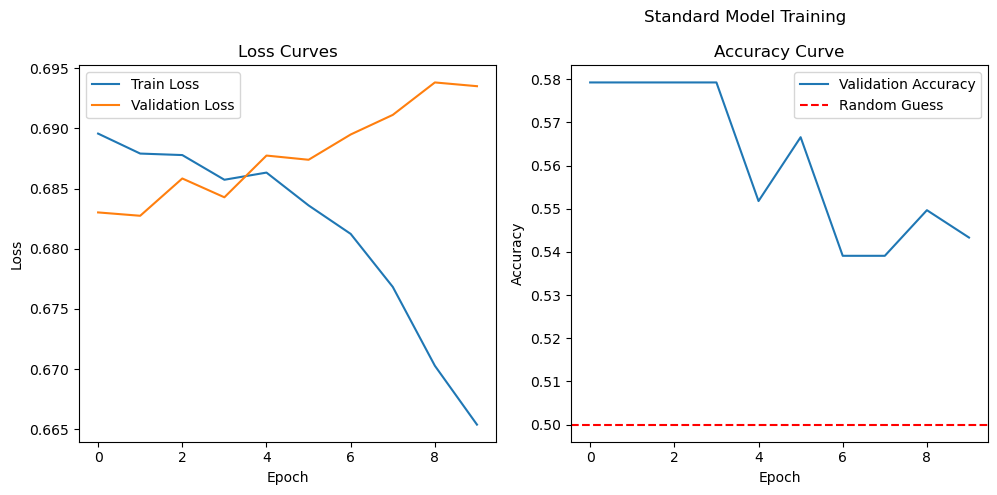

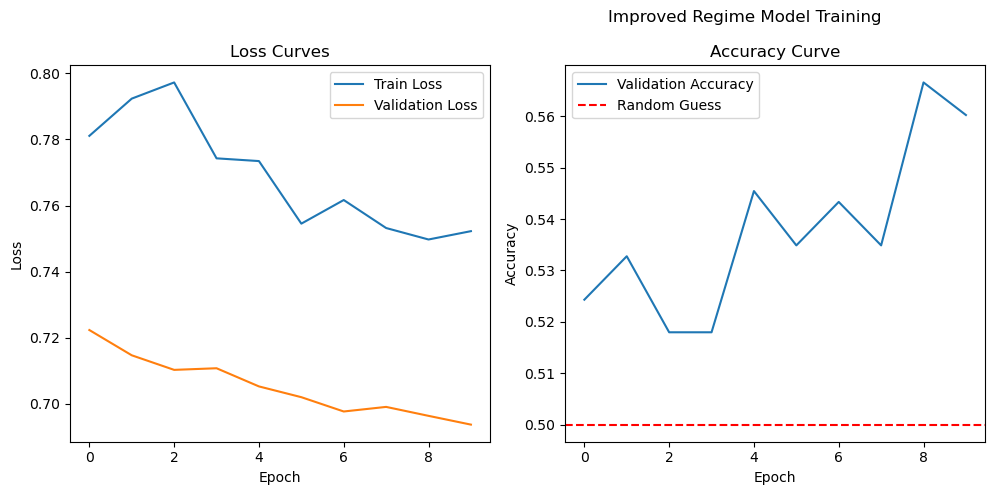

In [305]:
improved_regime_model = ImprovedRegimeModel(
    input_dimension=data_prep['input_dim'],
    num_of_regimes=data_prep['num_regimes'],
    hidden_dimensions=32,
    num_of_layers=1,
    dropout=0.4
).to(device)

historyImprovedRegimeWise = train_model(
    improved_regime_model,
    data_prep['train_loader'],
    data_prep['val_loader'],
    device,
    epochs=10,  
    lr=0.0002,
    regime_aware=True
)

# 4. Visualize training progress
plot_training_history(history, title="Standard Model Training")
plot_training_history(historyImprovedRegimeWise, title="Improved Regime Model Training")

This improved model has corrected the diverging loss curves, which is a postive sign in the success of implementing the L2 regularisation and higher dropout rates as regularisation techniques. Whilst reducing overfitting, however, there has been a performance trade-off with a higher overall loss and lower accuracy.

## Trading Strategy Evaluation:

Simply buying a stock or index fund and holding over a long period of time oftern returns a positive yield, so that will be used as the benchmark for each model and hence used to evaluate each model against. A cumulative return is calculated over the time period that the test data was used. This is assuming that every buy and sell is for the same notional amount (e.g buy $1, sell $1) and follows every buy and sell signal with the highest confidence for that day. This is also a fair approach, as it ignore market conditions. If over time the stock was to fall, it would have the same effect on accuracy and strategy return as if it was rising constantly, as the binary classifier allows a single final output to tell the system to simply buy or sell. The metrics used to measure the success of each model over the given time frame are:

- __Strategy Return__ : Measures the overall profitability of using the model as a basis for a trading strategy. It is a cumulative return when making the choices decided by the network on a given day.
- __Market Return__ : Provides a benchmark against the strategy return to identify how much the stock price has risen in the same period if you were to buy the stock and hold it.
- __Sharpe Ratio__ : A Risk Adjust Return measure, where a unit of return against a uit of 'risk'. The higher, the better.
- __Max Drawdown__ : MDD assesses the largest peak-to-trough decline in the given period. The lower this value is suggest less 'profit' or returns have been wiped out by poor decision later on.
- __Win Rate__ : A simple metric to assess the percentage of trade signals were decided correctly. A confusion matrix could have been used to see this, however due to the application and the binary classification of the models, this seems a better fit, altough not should what decisions were wrong more often.

It is also worth considering that within this context, win rate and return are not directly proportional. Included in the evaluation of the 'standard' numerical analysis model includes a confusion matrix for binary classification. This illustrates the important insights for trading, with :

- __True Positives__ : The model correctly predicts the price increasing, so performs a succesful buy.
- __False Positives__ : Incorrectly predicted the price to increase, so will lose money on that buy.
- __True Negatives__ : Correct prediction of the price decrease, so will avoid a loss or add to returns by selling.
- __False Negatives__ : Incorrectly predicted the market to decrease, so there is a missed opportunity to buy or could lose money if selling.

In [306]:
def evaluate_trading_strategy(model, test_data, test_loader, device, regime_aware=False):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch, regime_batch in test_loader:
            X_batch = X_batch.to(device)
            if regime_aware:
                regime_batch = regime_batch.to(device)
                y_pred = model(X_batch, regime_batch)
            else:
                y_pred = model(X_batch)
                
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    # Convert to arrays and adjust length
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Create binary trading signals (1 = buy, 0 = sell/don't buy)
    signals = (predictions > 0.5).astype(int)
    
    # Get the actual returns from the test data
    # (offset by sequence length since we're predicting future returns)
    seq_length = test_loader.dataset.seq_length
    test_returns = test_data['daily_return'].iloc[seq_length:seq_length+len(signals)].values
    
    # Calculate returns from the strategy
    # Strategy return is the market return when signal is 1, and 0 when signal is 0
    strategy_returns = signals * test_returns
    
    # Calculate cumulative returns
    cumulative_market_returns = (1 + test_returns).cumprod() - 1
    cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1
    
    # Calculate performance metrics
    sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)  # Annualized
    max_drawdown = np.max(np.maximum.accumulate(cumulative_strategy_returns) - 
                          cumulative_strategy_returns)
    total_return = cumulative_strategy_returns[-1]
    market_return = cumulative_market_returns[-1]
    win_rate = np.mean((signals == 1) & (test_returns > 0) | 
                       (signals == 0) & (test_returns <= 0))
    
    # Print performance summary
    print(f"Strategy Performance:")
    print(f"  - Total Return: {total_return:.2%}")
    print(f"  - Market Return: {market_return:.2%}")
    print(f"  - Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"  - Max Drawdown: {max_drawdown:.2%}")
    print(f"  - Win Rate: {win_rate:.2%}")
    
    # Store results
    results = {
        'signals': signals,
        'test_returns': test_returns,
        'strategy_returns': strategy_returns,
        'cumulative_market_returns': cumulative_market_returns,
        'cumulative_strategy_returns': cumulative_strategy_returns,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'total_return': total_return,
        'market_return': market_return,
        'win_rate': win_rate
    }
    
    return results

In [311]:
def plot_confusion_matrix(model, data_loader, device, regime_aware=False, title="Confusion Matrix"):
        
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch, regime_batch in data_loader:
            X_batch = X_batch.to(device)
            
            if regime_aware:
                regime_batch = regime_batch.to(device)
                y_pred = model(X_batch, regime_batch)
            else:
                y_pred = model(X_batch)
            
            # Convert predictions to binary (0 or 1)
            binary_preds = (y_pred.cpu() > 0.5).float().numpy()
            all_preds.extend(binary_preds)
            all_targets.extend(y_batch.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Create classification report
    report = classification_report(all_targets, all_preds, 
                                  target_names=['Down/Sell', 'Up/Buy'],
                                  output_dict=True)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Down/Sell', 'Up/Buy'],
                yticklabels=['Down/Sell', 'Up/Buy'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title}\nAccuracy: {report["accuracy"]:.2%}')
    
    # # Add precision, recall, and f1-score as text
    # textstr = '\n'.join((
    #     f"Buy Precision: {report['Up/Buy']['precision']:.2%}",
    #     f"Buy Recall: {report['Up/Buy']['recall']:.2%}",
    #     f"Buy F1-Score: {report['Up/Buy']['f1-score']:.2%}",
    #     f"Sell Precision: {report['Down/Sell']['precision']:.2%}",
    #     f"Sell Recall: {report['Down/Sell']['recall']:.2%}",
    #     f"Sell F1-Score: {report['Down/Sell']['f1-score']:.2%}"
    # ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    # plt.text(1.05, 1.1, transform=plt.gca().transAxes, 
    #          fontsize=10, verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return cm

In [308]:
def plot_strategy_returns(strategy_results, title="Trading Strategy Performance"):
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative returns
    plt.plot(strategy_results['cumulative_market_returns'], 
             label='Buy & Hold', color='blue')
    plt.plot(strategy_results['cumulative_strategy_returns'], 
             label='Model Strategy', color='green')
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Add labels and legend
    plt.title(title, fontsize=16)
    plt.xlabel('Trading Days', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add strategy performance summary as text box
    textstr = '\n'.join((
        f"Strategy Return: {strategy_results['total_return']:.2%}",
        f"Market Return: {strategy_results['market_return']:.2%}",
        f"Sharpe Ratio: {strategy_results['sharpe_ratio']:.2f}",
        f"Max Drawdown: {strategy_results['max_drawdown']:.2%}",
        f"Win Rate: {strategy_results['win_rate']:.2%}")
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()

## Comparing returns of different models

In [309]:
strategy_results1 = evaluate_trading_strategy(
    standard_model,
    data_prep['test_data'],
    data_prep['test_loader'],
    device,
    regime_aware=False
)

Strategy Performance:
  - Total Return: -1.09%
  - Market Return: 0.30%
  - Sharpe Ratio: 0.06
  - Max Drawdown: 24.17%
  - Win Rate: 49.37%


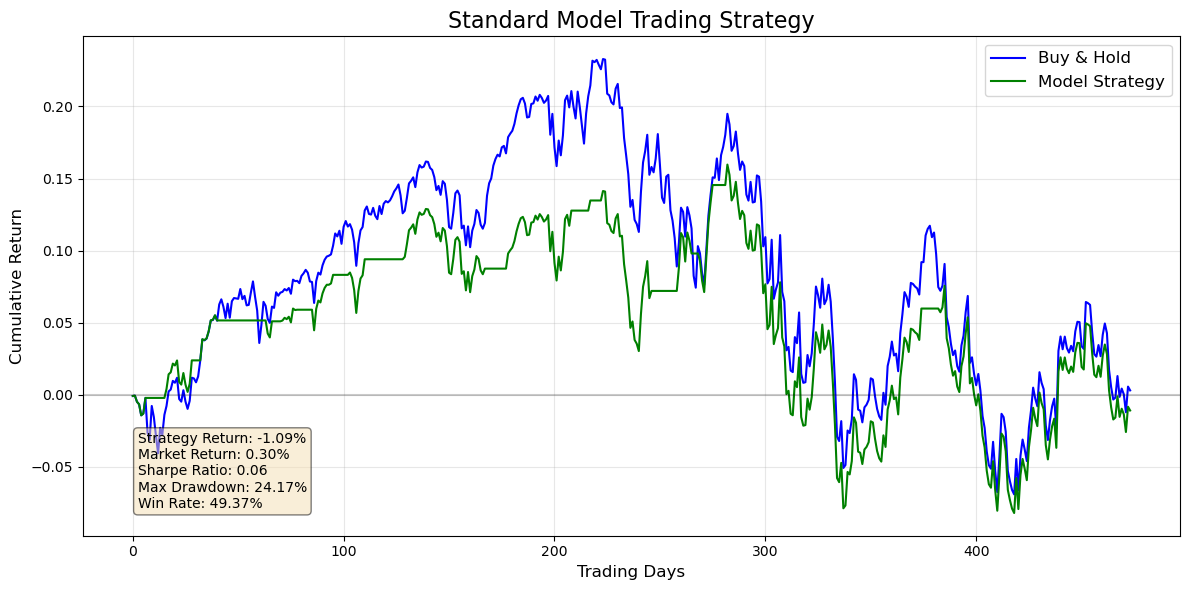

TypeError: text() missing 1 required positional argument: 's'

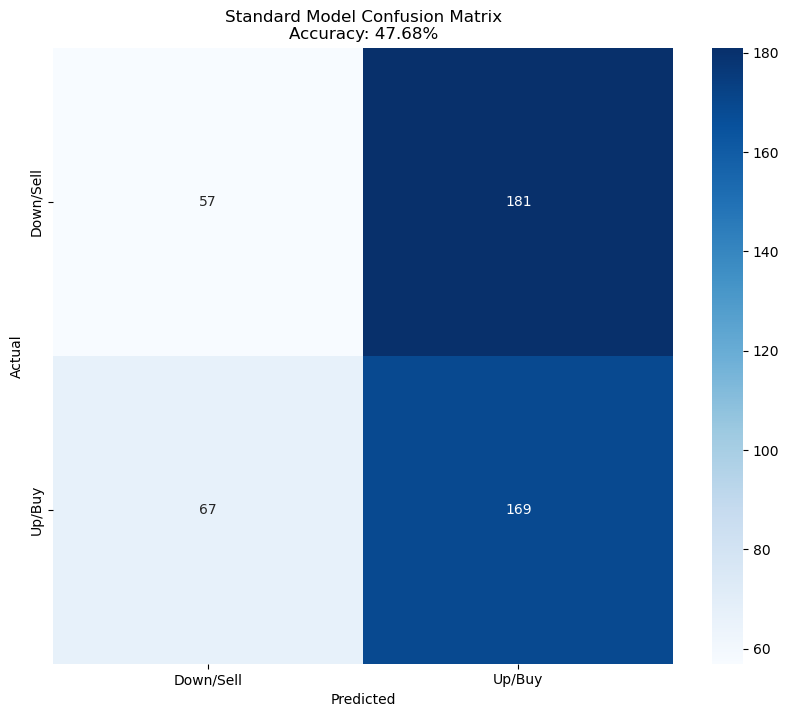

In [310]:
plot_strategy_returns(strategy_results1, title="Standard Model Trading Strategy")
plot_confusion_matrix(
    standard_model, 
    data_prep['test_loader'], 
    device, 
    regime_aware=False,
    title="Standard Model Confusion Matrix"
)


First is the standard model which does not have the embedded layer for learned market regimes. As shown above, this yield a -1.09% so following this strategy would lose them money in the testing period, and it failed to protect the cumulated return during market declines. It seems that this model was more optimistic, with a low sell accuracy, as it predicted a lot more Buy Signals than sell signals.

Strategy Performance:
  - Total Return: 2.36%
  - Market Return: 0.30%
  - Sharpe Ratio: 0.16
  - Max Drawdown: 24.10%
  - Win Rate: 48.31%


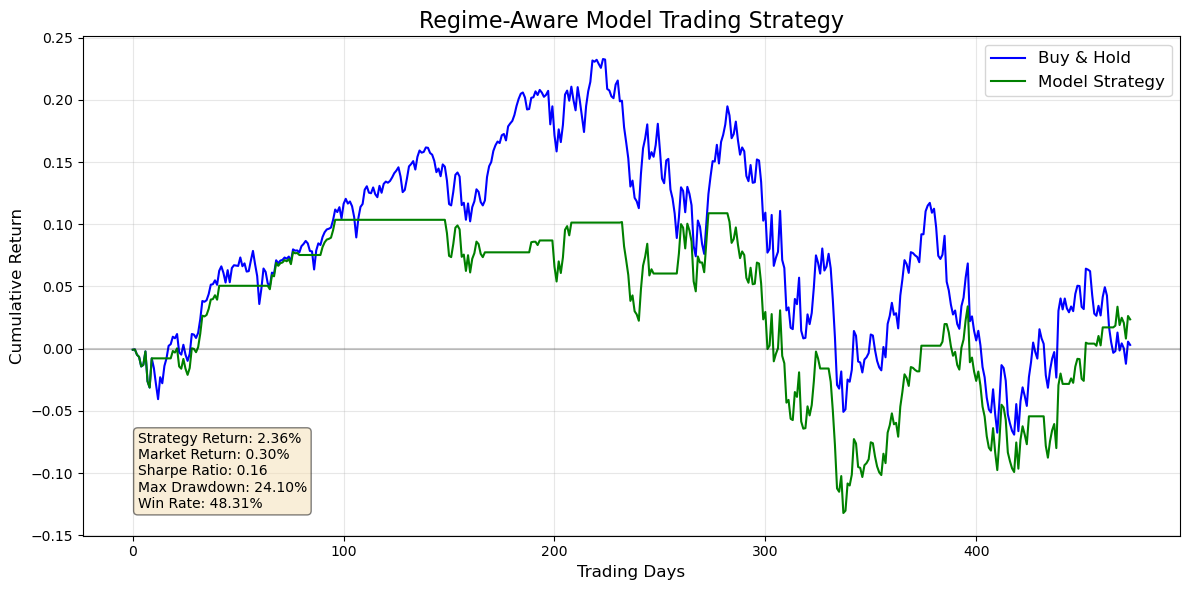

In [261]:
strategy_results2 = evaluate_trading_strategy(
    regime_model,
    data_prep['test_data'],
    data_prep['test_loader'],
    device,
    regime_aware=True
)
plot_strategy_returns(strategy_results2, title="Regime-Aware Model Trading Strategy")

The old Regime-Aware model did return a positive return (2.36% - 0.30%) and also a moderate Sharpe Ratio, however it had the loweest win rate of all three models, so it got the most decisions wrong.

Strategy Performance:
  - Total Return: 5.30%
  - Market Return: 0.30%
  - Sharpe Ratio: 0.24
  - Max Drawdown: 23.12%
  - Win Rate: 51.48%


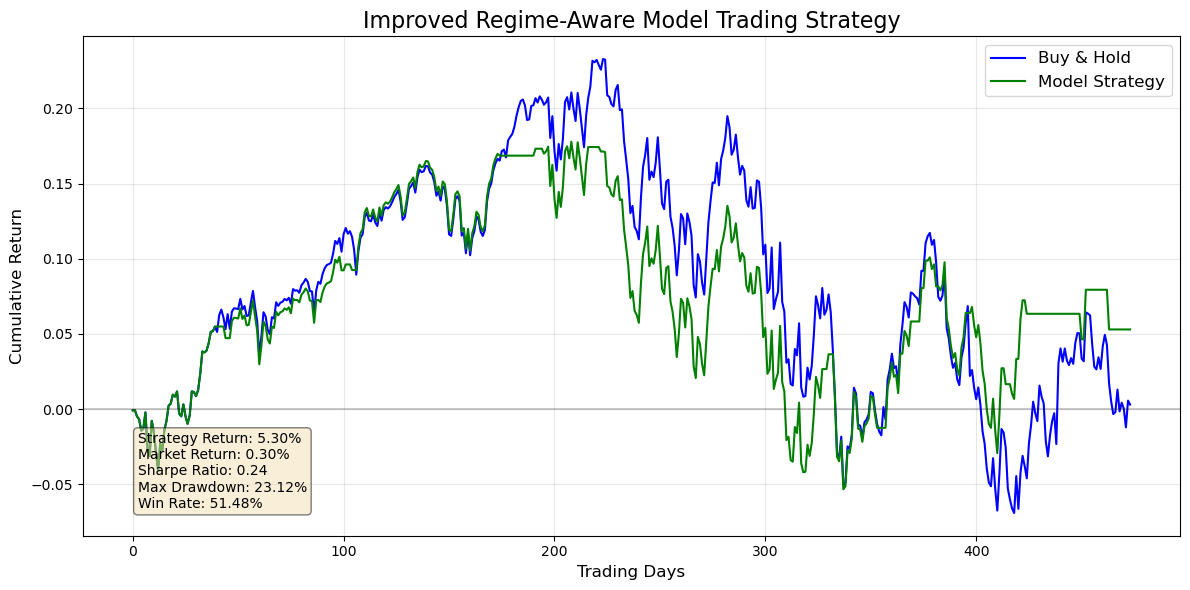

In [235]:
strategy_results3 = evaluate_trading_strategy(
    improved_regime_model,
    data_prep['test_data'],
    data_prep['test_loader'],
    device,
    regime_aware=True
)
plot_strategy_returns(strategy_results3, title="Improved Regime-Aware Model Trading Strategy")

## Evaluation of Strategy Return:

The improved regime-aware model had the highest return, best Sharpe Ratio, lowest drawdown and best win rate of the three models. This indicated that not only did it correctly predict the correct price movements, but it did so at the right times, as well as protecting the cumulative return in highly volatile times where the market dropped. This shows the model benefitted from the regime aware embedded layer and the additional regularisation techniques.

There are many external factors that contrbute to a stock price moving, most of which cannot be easily quantified and learnt by expert human economist. Sentiment analysis could potentially further improve the returns of this model, with more of a human-like understanding of the retail buyers feeling towards what will happen to the price that day. In some cases, it may be as simple as the weather being nice, and hence people are more optimistic and would like to buy the stock. Many quant funds, for example Renaissance Technolgies Medllion Fund who are one of the most succesful ever, reportedly have a hit rate slightly over 50%. 

Within this context, it would be fair to assume that this is improved model appears to be "better than nothing", as the win rate provides an indication that it has found a small, but potentially expolotable, market inefficiency. However, it is also worth considering transaction costs to the broker taht will eat into the gains, aswell as that in other datasets, other market regime clusters may appear, which the model is not as effective in working under.